In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import shapely as shp
import geopandas as gpd
import math
import random
import scipy.stats as stats
from glob import glob
import os
#from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import rmse

#PCA analysis
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import metrics

from matplotlib.colors import LogNorm, Normalize

from functions import *

In [2]:
pal = sns.color_palette('GnBu', 5)
pal

[(0.8535178777393311, 0.9429757785467128, 0.8314186851211073),
 (0.7058823529411765, 0.8849673202614379, 0.7307189542483661),
 (0.4795847750865052, 0.7984621299500193, 0.7695501730103806),
 (0.2601307189542484, 0.6509803921568628, 0.7999999999999999),
 (0.07497116493656286, 0.4526874279123414, 0.6969319492502883)]

## Data Imports

In [3]:
'''Import Data'''
path = './modeloutput' # use your path
modDat = pd.read_csv(path + '/rhino-data/processedData.csv')

In [4]:
modDat.head()

,stakes,northing,easting,zones,aspect,slope,watershed,SYear,maxDepth,Stake_ID,...,DBH_CM_SD,n,prop_Coniferous,Co,UnionMean,UnionSD,TotalMean,TotalSD,OverlapMean,OverlapSD
0,S200,464819.0,5262240.0,Upland,193.3626,6.632267,S2,2023,70.0,S200,...,7.624701,12,0.000000,7,5.378152,1.213219,5.378152,1.213219,0.000000,0.000000
1,S200,464819.0,5262240.0,Upland,193.3626,6.632267,S2,2024,22.0,S200,...,7.624701,12,0.000000,7,5.630910,1.172271,5.630910,1.172271,0.000000,0.000000
2,S201,464819.0,5262292.0,Upland,115.0966,3.120716,S2,2023,59.0,S201,...,11.569547,18,0.111111,9,34.116464,24.974351,34.780687,24.822905,0.664223,1.337429
3,S201,464819.0,5262292.0,Upland,115.0966,3.120716,S2,2024,18.0,S201,...,11.569547,18,0.111111,9,35.728379,27.771173,36.542468,27.750292,0.814089,1.384663
4,S203,464819.0,5262396.0,Upland,135.0012,7.452870,S2,2023,49.0,S203,...,3.984632,16,0.437500,11,38.300303,10.151985,41.322589,10.533758,3.022286,2.658763


In [5]:
modDat = modDat.rename(columns = {'OLS.Prediction.Ring.5' : 'LAI', 
                                  'prop_Coniferous' : 'pCon'})

## Exploratory Result Plots

c:\Users\marie\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\marie\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\marie\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 0, 'Volume [m3]')

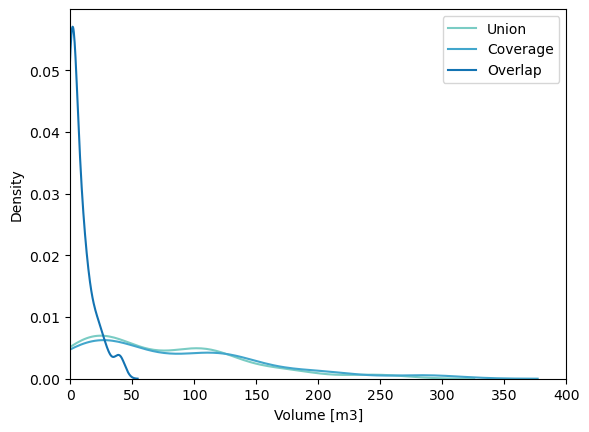

In [6]:
#General Site Statistics
fig, ax = plt.subplots(1, 1)
sns.kdeplot(data = modDat, x="UnionMean", label = 'Union', color = pal[2], ax = ax)
sns.kdeplot(data = modDat, x="TotalMean", label = 'Coverage', color = pal[3], ax = ax)
sns.kdeplot(data = modDat, x="OverlapMean", label = 'Overlap', color = pal[4], ax = ax)
ax.legend()
ax.set_xlim(0, 400)
#ax.set_ylim(0, 200)
ax.set_xlabel('Volume [m3]')

(0.0, 290.6884385585586)

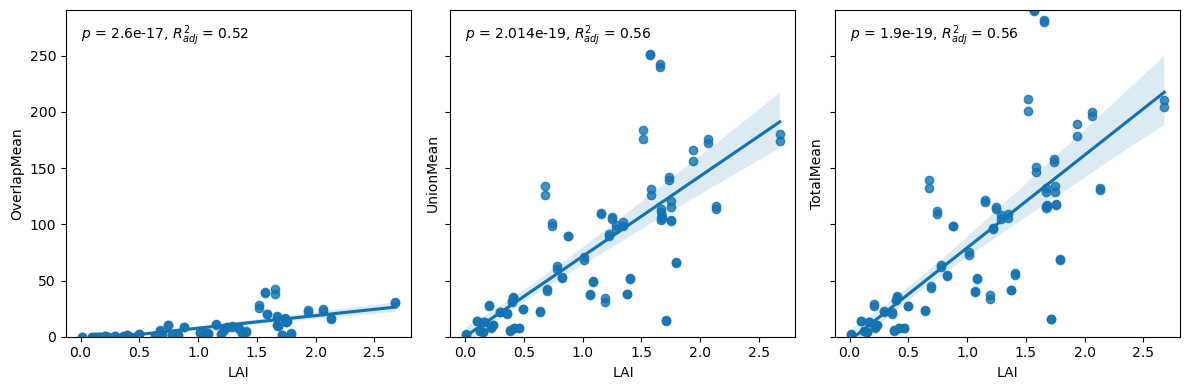

In [7]:
#Correlation with LAI
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize = (12, 4), 
                sharex = True,  
                sharey = True,
                layout = 'tight')

#average points
sns.regplot(data = modDat, x = 'LAI', y = 'OverlapMean',
                color = pal[4],
                ax = ax1)
sns.regplot(data = modDat, x = 'LAI', y = 'UnionMean',
                color = pal[4], 
                ax = ax2)
sns.regplot(data = modDat, x = 'LAI', y = 'TotalMean',
                color = pal[4], 
                ax = ax3)

#model labels
lai_pOver = smf.ols('OverlapMean ~ LAI', data = modDat).fit()
lai_pCover = smf.ols('UnionMean ~ LAI', data = modDat).fit()
lai_tot = smf.ols('TotalMean ~ LAI', data = modDat).fit()
ax1.text(0, 265, r'$ p $ = ' + str(round_sig(lai_pOver.pvalues.LAI, 2)) + r', $ R_{adj}^2 $ = ' + str(round_sig(lai_pOver.rsquared_adj, 2)))
ax2.text(0, 265, r'$ p $ = ' + '{:0.3e}'.format(lai_pCover.pvalues.LAI) + r', $ R_{adj}^2 $ = ' + str(round_sig(lai_pCover.rsquared_adj, 2)))
ax3.text(0, 265, r'$ p $ = ' + str(round_sig(lai_tot.pvalues.LAI, 2)) + r', $ R_{adj}^2 $ = ' + str(round_sig(lai_tot.rsquared_adj, 2)))

#other specs
ax1.set_ylim(0, max(modDat.OverlapMean))
ax2.set_ylim(0, max(modDat.UnionMean))
ax3.set_ylim(0, max(modDat.TotalMean))

(0.0, 290.6884385585586)

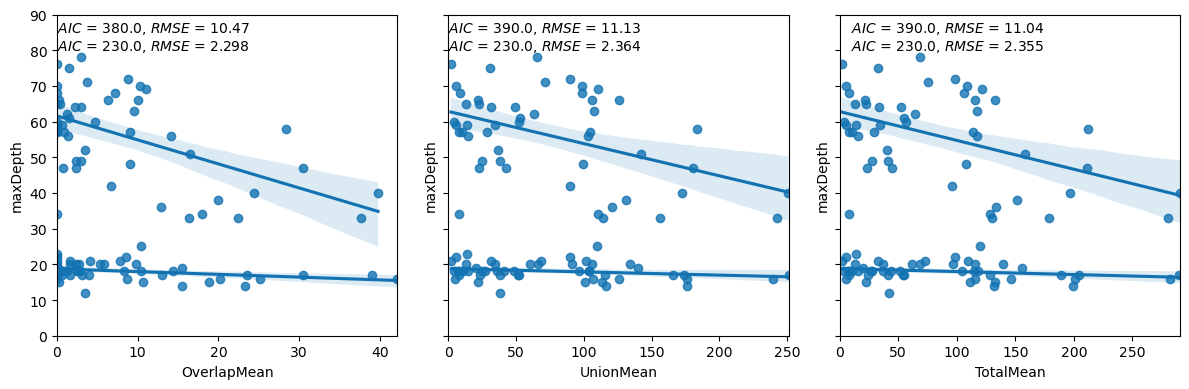

In [8]:
#Correlation with snow depth
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize = (12, 4), 
                #sharex = True, 
                sharey = True, 
                layout = 'tight')
#2023
#average points
sns.regplot(data = modDat[modDat.SYear == 2023], x = 'OverlapMean', y = 'maxDepth', order = 1,
                color = pal[4],
                ax = ax1)
sns.regplot(data = modDat[modDat.SYear == 2023], x = 'UnionMean', y = 'maxDepth', order = 1,
                color = pal[4], 
                ax = ax2)
sns.regplot(data = modDat[modDat.SYear == 2023], x = 'TotalMean', y = 'maxDepth', order = 1,
                color = pal[4], 
                ax = ax3)

#model labels
modDat['UnionMean2'] = modDat.UnionMean*modDat.UnionMean
pOver_SD2023 = smf.ols('maxDepth ~ OverlapMean', data = modDat[modDat.SYear == 2023]).fit()
pCover_SD2023 = smf.ols('maxDepth ~ UnionMean', data = modDat[modDat.SYear == 2023]).fit()
Total_SD2023 = smf.ols('maxDepth ~ TotalMean', data = modDat[modDat.SYear == 2023]).fit()

#2024
#average points
sns.regplot(data = modDat[modDat.SYear == 2024], x = 'OverlapMean', y = 'maxDepth', order = 1,
                color = pal[4],
                ax = ax1)
sns.regplot(data = modDat[modDat.SYear == 2024], x = 'UnionMean', y = 'maxDepth', order = 1,
                color = pal[4], 
                ax = ax2)
sns.regplot(data = modDat[modDat.SYear == 2024], x = 'TotalMean', y = 'maxDepth', order = 1,
                color = pal[4], 
                ax = ax3)

#model labels
modDat['UnionMean2'] = modDat.UnionMean*modDat.UnionMean
pOver_SD2024 = smf.ols('maxDepth ~ OverlapMean', data = modDat[modDat.SYear == 2024]).fit()
pCover_SD2024 = smf.ols('maxDepth ~ UnionMean', data = modDat[modDat.SYear == 2024]).fit()
Total_SD2024 = smf.ols('maxDepth ~ TotalMean', data = modDat[modDat.SYear == 2024]).fit()

#ax1.text(0.6, 85, r'$ p $ = ' + str(round_sig(pOver_SD2023.pvalues.OverlapMean, 2)) + r', $ R_{adj}^2 $ = ' + str(round_sig(pOver_SD2023.rsquared_adj, 2)))
#ax2.text(0.6, 85, r'$ p $ = ' + str(round_sig(pCover_SD2023.pvalues.UnionMean2, 2)) + r', $ R_{adj}^2 $ = ' + str(round_sig(pCover_SD2023.rsquared_adj, 2)))
#ax1.text(0.6, 80, r'$ p $ = ' + str(round_sig(pOver_SD2024.pvalues.OverlapMean, 2)) + r', $ R_{adj}^2 $ = ' + str(round_sig(pOver_SD2024.rsquared_adj, 2)))
#ax2.text(0.6, 80, r'$ p $ = ' + str(round_sig(pCover_SD2024.pvalues.UnionMean, 2)) + r', $ R_{adj}^2 $ = ' + str(round_sig(pCover_SD2024.rsquared_adj, 2)))

y2023 =  modDat[modDat.SYear == 2023].maxDepth
y2024 =  modDat[modDat.SYear == 2024].maxDepth
ax1.text(0.002, 85, r'$ AIC $ = ' + str(round_sig(pOver_SD2023.aic, 2)) + r', $ RMSE $ = ' + str(round_sig(rmse(y2023, pOver_SD2023.fittedvalues), 4)))
ax2.text(0.05, 85, r'$ AIC $ = ' + str(round_sig(pCover_SD2023.aic, 2)) + r', $ RMSE $ = ' + str(round_sig(rmse(y2023, pCover_SD2023.fittedvalues), 4)))
ax3.text(10, 85, r'$ AIC $ = ' + str(round_sig(Total_SD2023.aic, 2)) + r', $ RMSE $ = ' + str(round_sig(rmse(y2023, Total_SD2023.fittedvalues), 4)))
ax1.text(0.002, 80, r'$ AIC $ = ' + str(round_sig(pOver_SD2024.aic, 2)) + r', $ RMSE $ = ' + str(round_sig(rmse(y2024, pOver_SD2024.fittedvalues), 4)))
ax2.text(0.05, 80, r'$ AIC $ = ' + str(round_sig(pCover_SD2024.aic, 2)) + r', $ RMSE $ = ' + str(round_sig(rmse(y2024, pCover_SD2024.fittedvalues), 4)))
ax3.text(10, 80, r'$ AIC $ = ' + str(round_sig(Total_SD2024.aic, 2)) + r', $ RMSE $ = ' + str(round_sig(rmse(y2024, Total_SD2024.fittedvalues), 4)))

ax1.set_ylim(0, 90)
ax1.set_xlim(0, np.nanmax(modDat.OverlapMean))
ax2.set_xlim(0, np.nanmax(modDat.UnionMean))
ax3.set_xlim(0, np.nanmax(modDat.TotalMean))

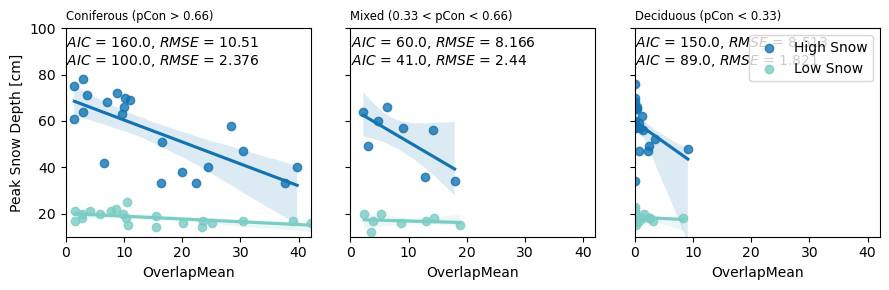

In [9]:
#Separate out overlap model by coniferous proportion
#Prep Data
bins = list(np.linspace(np.nanmin(modDat.pCon), np.nanmax(modDat.pCon), 4))
labels = ['Dense Deciduous', 'Mixed', 'Dense Coniferous']
modDat['Bin'] = pd.cut(modDat['pCon'], include_lowest = True, bins = bins, labels = labels)

#Plot
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize = (9, 3), 
                                    sharex = True, 
                                    sharey = True, 
                                    layout = 'tight')

sns.regplot(data = modDat[(modDat.Bin == 'Dense Coniferous') & (modDat.SYear == 2023)], x = 'OverlapMean', y = 'maxDepth', 
            ax = ax1, 
            color = pal[4], 
            label = 'High Snow')
sns.regplot(data = modDat[(modDat.Bin == 'Dense Coniferous') & (modDat.SYear == 2024)], x = 'OverlapMean', y = 'maxDepth', 
            ax = ax1, 
            color = pal[2], 
            label = 'Low Snow')
resultsDenseCon_high = smf.ols('maxDepth ~ OverlapMean', data = modDat[(modDat.Bin == 'Dense Coniferous') & (modDat.SYear == 2023)]).fit()
resultsDenseCon_low = smf.ols('maxDepth ~ OverlapMean', data = modDat[(modDat.Bin == 'Dense Coniferous') & (modDat.SYear == 2024)]).fit()
y2023_1 = modDat[(modDat.Bin == 'Dense Coniferous') & (modDat.SYear == 2023)].maxDepth
y2024_1 = modDat[(modDat.Bin == 'Dense Coniferous') & (modDat.SYear == 2024)].maxDepth
ax1.text(0.1, 92, r'$ AIC $ = ' + str(round_sig(resultsDenseCon_high.aic, 2)) + r', $ RMSE $ = ' + str(round_sig(rmse(y2023_1, resultsDenseCon_high.fittedvalues), 4)))
ax1.text(0.1, 84, r'$ AIC $ = ' + str(round_sig(resultsDenseCon_low.aic, 2)) + r', $ RMSE $ = ' + str(round_sig(rmse(y2024_1, resultsDenseCon_low.fittedvalues), 4)))
ax1.set_title('Coniferous (pCon > 0.66)', fontsize='small', loc='left')
ax1.set_ylabel('Peak Snow Depth [cm]')
ax1.set_xlabel('OverlapMean')

sns.regplot(data = modDat[(modDat.Bin == 'Mixed') & (modDat.SYear == 2023)], x = 'OverlapMean', y = 'maxDepth', 
            ax = ax2, 
            color = pal[4])
sns.regplot(data = modDat[(modDat.Bin == 'Mixed') & (modDat.SYear == 2024)], x = 'OverlapMean', y = 'maxDepth', 
            ax = ax2, 
            color = pal[2])
resultsMixed_high = smf.ols('maxDepth ~ OverlapMean', data = modDat[(modDat.Bin == 'Mixed') & (modDat.SYear == 2023)]).fit()
resultsMixed_low = smf.ols('maxDepth ~ OverlapMean', data = modDat[(modDat.Bin == 'Mixed') & (modDat.SYear == 2024)]).fit()
y2023_2 = modDat[(modDat.Bin == 'Mixed') & (modDat.SYear == 2023)].maxDepth
y2024_2 = modDat[(modDat.Bin == 'Mixed') & (modDat.SYear == 2024)].maxDepth
ax2.text(0.1, 92, r'$ AIC $ = ' + str(round_sig(resultsMixed_high.aic, 2)) + r', $ RMSE $ = ' + str(round_sig(rmse(y2023_2, resultsMixed_high.fittedvalues), 4)))
ax2.text(0.1, 84, r'$ AIC $ = ' + str(round_sig(resultsMixed_low.aic, 2)) + r', $ RMSE $ = ' + str(round_sig(rmse(y2024_2, resultsMixed_low.fittedvalues), 4)))
ax2.set_title('Mixed (0.33 < pCon < 0.66)', fontsize='small', loc='left')
ax2.set_ylabel(' ')
ax2.set_xlabel('OverlapMean')

sns.regplot(data = modDat[(modDat.Bin == 'Dense Deciduous') & (modDat.SYear == 2023)], x = 'OverlapMean', y = 'maxDepth', 
            ax = ax3, 
            color = pal[4], 
            label = 'High Snow')
sns.regplot(data = modDat[(modDat.Bin == 'Dense Deciduous') & (modDat.SYear == 2024)], x = 'OverlapMean', y = 'maxDepth', 
            ax = ax3, 
            color = pal[2], 
            label = 'Low Snow')
resultsDenseDec_high = smf.ols('maxDepth ~ OverlapMean', data = modDat[(modDat.Bin == 'Dense Deciduous') & (modDat.SYear == 2023)]).fit()
resultsDenseDec_low = smf.ols('maxDepth ~ OverlapMean', data = modDat[(modDat.Bin == 'Dense Deciduous') & (modDat.SYear == 2024)]).fit()
y2023_3 = modDat[(modDat.Bin == 'Dense Deciduous') & (modDat.SYear == 2023)].maxDepth
y2024_3 = modDat[(modDat.Bin == 'Dense Deciduous') & (modDat.SYear == 2024)].maxDepth
ax3.text(0.1, 92, r'$ AIC $ = ' + str(round_sig(resultsDenseDec_high.aic, 2)) + r', $ RMSE $ = ' + str(round_sig(rmse(y2023_3, resultsDenseDec_high.fittedvalues), 4)))
ax3.text(0.1, 84, r'$ AIC $ = ' + str(round_sig(resultsDenseDec_low.aic, 2)) + r', $ RMSE $ = ' + str(round_sig(rmse(y2024_3, resultsDenseDec_low.fittedvalues), 4)))
ax3.set_title('Deciduous (pCon < 0.33)', fontsize='small', loc='left')
ax3.set_ylabel(' ')
ax3.set_xlabel('OverlapMean')

ax1.set_xlim(0, max(modDat.OverlapMean))
ax1.set_ylim(10, 100)
ax3.legend(bbox_to_anchor = (1, 1))

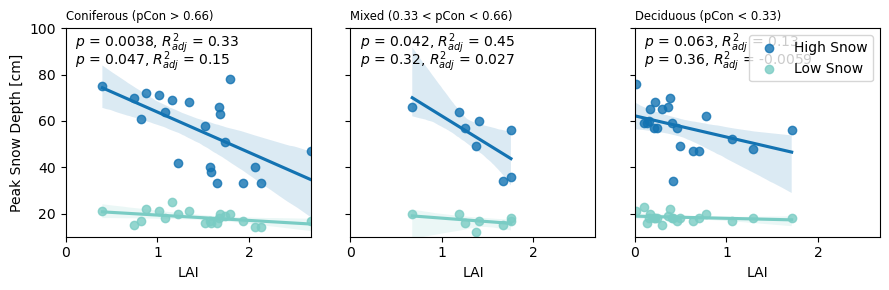

In [10]:
#Separate out overlap model by coniferous proportion
#Prep Data
bins = list(np.linspace(np.nanmin(modDat.pCon), np.nanmax(modDat.pCon), 4))
labels = ['Dense Deciduous', 'Mixed', 'Dense Coniferous']
modDat['Bin'] = pd.cut(modDat['pCon'], include_lowest = True, bins = bins, labels = labels)

#Plot
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize = (9, 3), 
                                    sharex = True, 
                                    sharey = True, 
                                    layout = 'tight')

sns.regplot(data = modDat[(modDat.Bin == 'Dense Coniferous') & (modDat.SYear == 2023)], x = 'LAI', y = 'maxDepth', 
            ax = ax1, 
            color = pal[4], 
            label = 'High Snow')
sns.regplot(data = modDat[(modDat.Bin == 'Dense Coniferous') & (modDat.SYear == 2024)], x = 'LAI', y = 'maxDepth', 
            ax = ax1, 
            color = pal[2], 
            label = 'Low Snow')
resultsDenseCon_high = smf.ols('maxDepth ~ LAI', data = modDat[(modDat.Bin == 'Dense Coniferous') & (modDat.SYear == 2023)]).fit()
resultsDenseCon_low = smf.ols('maxDepth ~ LAI', data = modDat[(modDat.Bin == 'Dense Coniferous') & (modDat.SYear == 2024)]).fit()
y2023_1 = modDat[(modDat.Bin == 'Dense Coniferous') & (modDat.SYear == 2023)].maxDepth
y2024_1 = modDat[(modDat.Bin == 'Dense Coniferous') & (modDat.SYear == 2024)].maxDepth
#ax1.text(0.1, 92, r'$ AIC $ = ' + str(round_sig(resultsDenseCon_high.aic, 2)) + r', $ RMSE $ = ' + str(round_sig(rmse(y2023_1, resultsDenseCon_high.fittedvalues), 4)))
ax1.text(0.1, 92, r'$ p $ = ' + str(round_sig(resultsDenseCon_high.pvalues.LAI, 2)) + r', $ R_{adj}^2 $ = ' + str(round_sig(resultsDenseCon_high.rsquared_adj, 2)))
#ax1.text(0.1, 84, r'$ AIC $ = ' + str(round_sig(resultsDenseCon_low.aic, 2)) + r', $ RMSE $ = ' + str(round_sig(rmse(y2024_1, resultsDenseCon_low.fittedvalues), 4)))
ax1.text(0.1, 84, r'$ p $ = ' + str(round_sig(resultsDenseCon_low.pvalues.LAI, 2)) + r', $ R_{adj}^2 $ = ' + str(round_sig(resultsDenseCon_low.rsquared_adj, 2)))
ax1.set_title('Coniferous (pCon > 0.66)', fontsize='small', loc='left')
ax1.set_ylabel('Peak Snow Depth [cm]')
ax1.set_xlabel('LAI')

sns.regplot(data = modDat[(modDat.Bin == 'Mixed') & (modDat.SYear == 2023)], x = 'LAI', y = 'maxDepth', 
            ax = ax2, 
            color = pal[4])
sns.regplot(data = modDat[(modDat.Bin == 'Mixed') & (modDat.SYear == 2024)], x = 'LAI', y = 'maxDepth', 
            ax = ax2, 
            color = pal[2])
resultsMixed_high = smf.ols('maxDepth ~ LAI', data = modDat[(modDat.Bin == 'Mixed') & (modDat.SYear == 2023)]).fit()
resultsMixed_low = smf.ols('maxDepth ~ LAI', data = modDat[(modDat.Bin == 'Mixed') & (modDat.SYear == 2024)]).fit()
y2023_2 = modDat[(modDat.Bin == 'Mixed') & (modDat.SYear == 2023)].maxDepth
y2024_2 = modDat[(modDat.Bin == 'Mixed') & (modDat.SYear == 2024)].maxDepth
#ax2.text(0.1, 92, r'$ AIC $ = ' + str(round_sig(resultsMixed_high.aic, 2)) + r', $ RMSE $ = ' + str(round_sig(rmse(y2023_2, resultsMixed_high.fittedvalues), 4)))
ax2.text(0.1, 92, r'$ p $ = ' + str(round_sig(resultsMixed_high.pvalues.LAI, 2)) + r', $ R_{adj}^2 $ = ' + str(round_sig(resultsMixed_high.rsquared_adj, 2)))
#ax2.text(0.1, 84, r'$ AIC $ = ' + str(round_sig(resultsMixed_low.aic, 2)) + r', $ RMSE $ = ' + str(round_sig(rmse(y2024_2, resultsMixed_low.fittedvalues), 4)))
ax2.text(0.1, 84, r'$ p $ = ' + str(round_sig(resultsMixed_low.pvalues.LAI, 2)) + r', $ R_{adj}^2 $ = ' + str(round_sig(resultsMixed_low.rsquared_adj, 2)))
ax2.set_title('Mixed (0.33 < pCon < 0.66)', fontsize='small', loc='left')
ax2.set_ylabel(' ')
ax2.set_xlabel('LAI')

sns.regplot(data = modDat[(modDat.Bin == 'Dense Deciduous') & (modDat.SYear == 2023)], x = 'LAI', y = 'maxDepth', 
            ax = ax3, 
            color = pal[4], 
            label = 'High Snow')
sns.regplot(data = modDat[(modDat.Bin == 'Dense Deciduous') & (modDat.SYear == 2024)], x = 'LAI', y = 'maxDepth', 
            ax = ax3, 
            color = pal[2], 
            label = 'Low Snow')
resultsDenseDec_high = smf.ols('maxDepth ~ LAI', data = modDat[(modDat.Bin == 'Dense Deciduous') & (modDat.SYear == 2023)]).fit()
resultsDenseDec_low = smf.ols('maxDepth ~ LAI', data = modDat[(modDat.Bin == 'Dense Deciduous') & (modDat.SYear == 2024)]).fit()
y2023_3 = modDat[(modDat.Bin == 'Dense Deciduous') & (modDat.SYear == 2023)].maxDepth
y2024_3 = modDat[(modDat.Bin == 'Dense Deciduous') & (modDat.SYear == 2024)].maxDepth
#ax3.text(0.1, 92, r'$ AIC $ = ' + str(round_sig(resultsDenseDec_high.aic, 2)) + r', $ RMSE $ = ' + str(round_sig(rmse(y2023_3, resultsDenseDec_high.fittedvalues), 4)))
ax3.text(0.1, 92, r'$ p $ = ' + str(round_sig(resultsDenseDec_high.pvalues.LAI, 2)) + r', $ R_{adj}^2 $ = ' + str(round_sig(resultsDenseDec_high.rsquared_adj, 2)))
#ax3.text(0.1, 84, r'$ AIC $ = ' + str(round_sig(resultsDenseDec_low.aic, 2)) + r', $ RMSE $ = ' + str(round_sig(rmse(y2024_3, resultsDenseDec_low.fittedvalues), 4)))
ax3.text(0.1, 84, r'$ p $ = ' + str(round_sig(resultsDenseDec_low.pvalues.LAI, 2)) + r', $ R_{adj}^2 $ = ' + str(round_sig(resultsDenseDec_low.rsquared_adj, 2)))
ax3.set_title('Deciduous (pCon < 0.33)', fontsize='small', loc='left')
ax3.set_ylabel(' ')
ax3.set_xlabel('LAI')

ax1.set_xlim(0, max(modDat.LAI))
ax1.set_ylim(10, 100)
ax3.legend(bbox_to_anchor = (1, 1))
plt.savefig('./figures/WaterSciCon/lai_covertype_breakdown.pdf')

Text(0, 0.5, 'Mean Model Overlap [m2]')

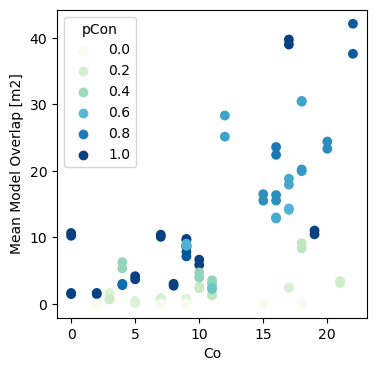

In [11]:
#pCo and overlap
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
sns.scatterplot(data = modDat, x = 'Co', y = 'OverlapMean',
                hue = 'pCon',
                s =  50,
                palette = 'GnBu',
                edgecolor = 'None',
                ax = ax)
ax.set_ylabel('Mean Model Overlap [m2]')

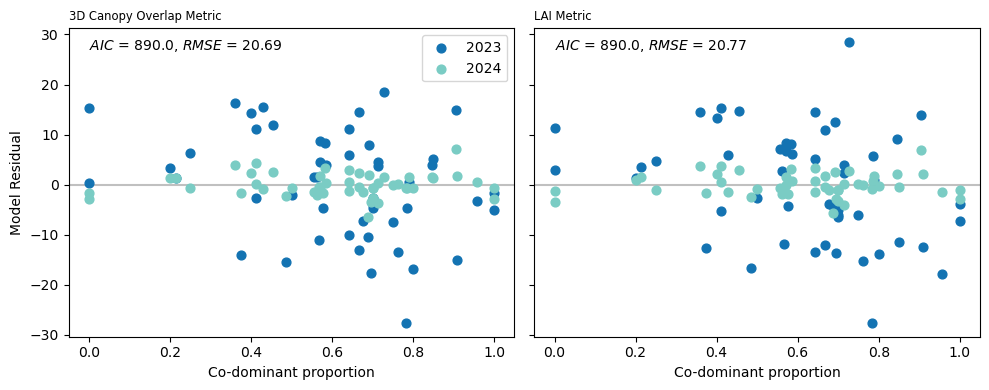

In [12]:
#Model error vs pCo
modDat['pCo'] = modDat['Co']/modDat['n']
overlapMod2023 = smf.ols('maxDepth ~ OverlapMean', data = modDat[modDat.SYear == 2023]).fit()
overlapMod2024 = smf.ols('maxDepth ~ OverlapMean', data = modDat[modDat.SYear == 2024]).fit()
overlapMod = smf.ols('maxDepth ~ OverlapMean', data = modDat).fit()
laiMod2023 = smf.ols('maxDepth ~ LAI', data = modDat[modDat.SYear == 2023]).fit()
laiMod2024 = smf.ols('maxDepth ~ LAI', data = modDat[modDat.SYear == 2024]).fit()
laiMod = smf.ols('maxDepth ~ LAI', data = modDat).fit()

fig, [ax1, ax2] = plt.subplots(1, 2, figsize = (10, 4), 
                               sharex = True, 
                               sharey = True, 
                               layout = 'tight')

ax1.axhline(0, color = 'silver')
ax2.axhline(0, color = 'silver')

#pOverlap
#2023
ax1.scatter(modDat[modDat.SYear == 2023].pCo, overlapMod2023.resid, color = pal[4], 
           zorder = 2, 
           s = 40, 
           label = '2023',)
ax2.scatter(modDat[modDat.SYear == 2023].pCo, laiMod2023.resid, color = pal[4], 
           s = 40, 
           zorder = 2)
#2024
ax1.scatter(modDat[modDat.SYear == 2024].pCo, overlapMod2024.resid, color = pal[2], 
           zorder = 2,
           s = 40, 
           label = '2024')
ax2.scatter(modDat[modDat.SYear == 2024].pCo, laiMod2024.resid, color = pal[2], 
           s = 40, 
           zorder = 2)


#Labels
y = modDat.maxDepth
ax1.text(0, 27,
        r'$ AIC $ = ' + str(round_sig(overlapMod.aic, 2)) + r', $ RMSE $ = ' + str(round_sig(rmse(y, overlapMod.fittedvalues), 4)))
ax2.text(0, 27,
        r'$ AIC $ = ' + str(round_sig(laiMod.aic, 2)) + r', $ RMSE $ = ' + str(round_sig(rmse(y, laiMod.fittedvalues), 4)))


ax1.set_title('3D Canopy Overlap Metric', fontsize='small', loc='left')
ax2.set_title('LAI Metric', fontsize='small', loc='left')
ax1.set_xlabel('Co-dominant proportion')
ax2.set_xlabel('Co-dominant proportion')
ax1.set_ylabel('Model Residual')
ax1.legend()


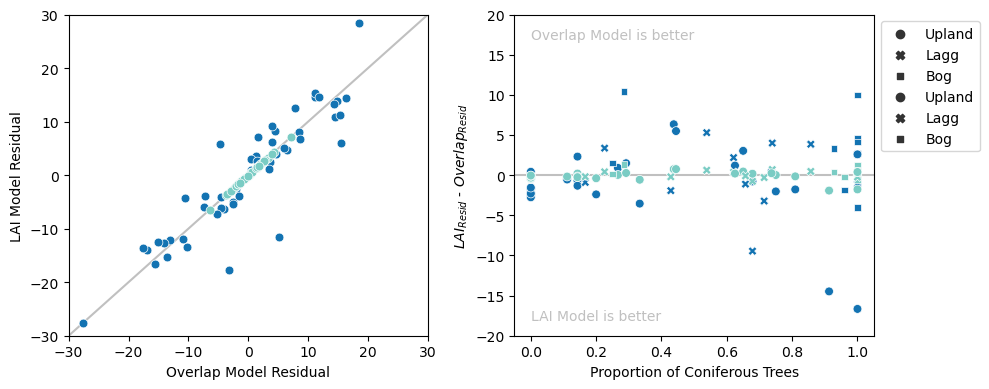

In [13]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize = (10, 4), 
                               #sharex = True, 
                               #sharey = True, 
                               layout = 'tight')

ax1.axline((0, 0), slope = 1, color = 'silver')

sns.scatterplot(x = overlapMod2023.resid, y = laiMod2023.resid, color = pal[4], 
            #hue = modDat[modDat.SYear == 2023].pCon,
            zorder = 2, s = 40, label = '2023', ax = ax1)
sns.scatterplot(x = overlapMod2024.resid, y = overlapMod2024.resid, color = pal[2],
            #hue = modDat[modDat.SYear == 2024].pCon,
            zorder = 2, s = 40, label = '2024', ax = ax1)

ax2.axhline(0, color = 'silver')
sns.scatterplot(x = modDat[modDat.SYear == 2023].pCon, y = laiMod2023.resid - overlapMod2023.resid, color = pal[4], 
            style = modDat[modDat.SYear == 2023].zones,
            zorder = 2, s= 40, ax = ax2)
sns.scatterplot(x = modDat[modDat.SYear == 2024].pCon, y = laiMod2024.resid - overlapMod2024.resid, color = pal[2],
            style = modDat[modDat.SYear == 2024].zones,
            zorder = 2, s = 40, ax = ax2)

ax1.set_xlim(-30, 30)
ax1.set_ylim(-30, 30)
ax2.set_ylim(-20, 20)
ax1.set_xlabel('Overlap Model Residual')
ax1.set_ylabel('LAI Model Residual')
ax2.set_xlabel('Proportion of Coniferous Trees')
ax2.set_ylabel(r'$LAI_{Resid}$ - $Overlap_{Resid}$')
ax2.text(0, -18, 'LAI Model is better', color = 'silver')
ax2.text(0, 17, 'Overlap Model is better', color = 'silver')
ax1.get_legend().remove()
ax2.legend(bbox_to_anchor = (1, 1))

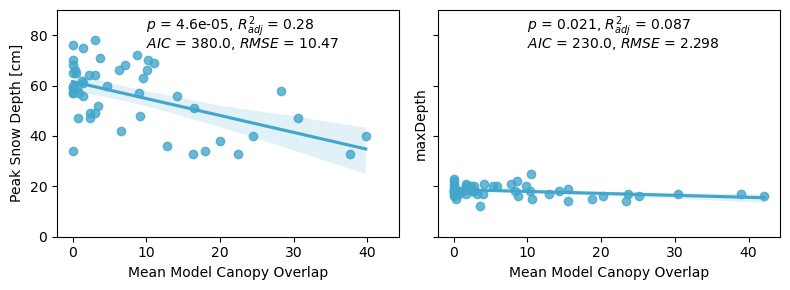

In [14]:

fig, [ax, ax2] = plt.subplots(1, 2, figsize = (8, 3), 
                              sharex = True, 
                              sharey = True, 
                              layout = 'tight')

overlapMod2023 = smf.ols('maxDepth ~ OverlapMean', data = modDat[modDat.SYear == 2023]).fit()
sns.regplot(data = modDat[modDat.SYear == 2023], x = 'OverlapMean', y = 'maxDepth',
            color = pal[3], 
            ax = ax)
ax.text(10, 82, r'$ p $ = ' + str(round_sig(overlapMod2023.pvalues.OverlapMean, 2)) + r', $ R_{adj}^2 $ = ' + str(round_sig(overlapMod2023.rsquared_adj, 2)))
ax.text(10, 75,
        r'$ AIC $ = ' + str(round_sig(overlapMod2023.aic, 2)) + r', $ RMSE $ = ' + str(round_sig(rmse(modDat[modDat.SYear == 2023].maxDepth, overlapMod2023.fittedvalues), 4)))

overlapMod2024 = smf.ols('maxDepth ~ OverlapMean', data = modDat[modDat.SYear == 2024]).fit()
sns.regplot(data = modDat[modDat.SYear == 2024], x = 'OverlapMean', y = 'maxDepth',
            color = pal[3], 
            ax = ax2)
ax2.text(10, 82, r'$ p $ = ' + str(round_sig(overlapMod2024.pvalues.OverlapMean, 2)) + r', $ R_{adj}^2 $ = ' + str(round_sig(overlapMod2024.rsquared_adj, 2)))
ax2.text(10, 75,
        r'$ AIC $ = ' + str(round_sig(overlapMod2024.aic, 2)) + r', $ RMSE $ = ' + str(round_sig(rmse(modDat[modDat.SYear == 2024].maxDepth, overlapMod2024.fittedvalues), 4)))

ax.set_ylabel('Peak Snow Depth [cm]')
ax.set_xlabel('Mean Model Canopy Overlap')
ax2.set_xlabel('Mean Model Canopy Overlap')
ax.set_ylim(0, 90)
plt.savefig('./figures/WaterSciCon/overlap_correlationPlot.pdf', bbox_inches = 'tight')

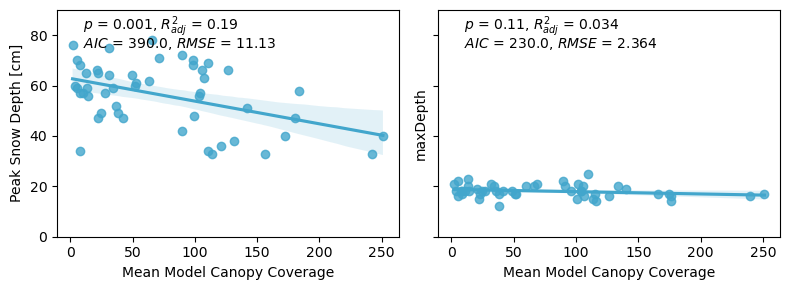

In [15]:

fig, [ax, ax2] = plt.subplots(1, 2, figsize = (8, 3), 
                              sharex = True, 
                              sharey = True, 
                              layout = 'tight')

totalMod2023 = smf.ols('maxDepth ~ UnionMean', data = modDat[modDat.SYear == 2023]).fit()
sns.regplot(data = modDat[modDat.SYear == 2023], x = 'UnionMean', y = 'maxDepth',
            color = pal[3], 
            ax = ax)
ax.text(10, 82, r'$ p $ = ' + str(round_sig(totalMod2023.pvalues.UnionMean, 2)) + r', $ R_{adj}^2 $ = ' + str(round_sig(totalMod2023.rsquared_adj, 2)))
ax.text(10, 75,
        r'$ AIC $ = ' + str(round_sig(totalMod2023.aic, 2)) + r', $ RMSE $ = ' + str(round_sig(rmse(modDat[modDat.SYear == 2023].maxDepth, totalMod2023.fittedvalues), 4)))

totalMod2024 = smf.ols('maxDepth ~ UnionMean', data = modDat[modDat.SYear == 2024]).fit()
sns.regplot(data = modDat[modDat.SYear == 2024], x = 'UnionMean', y = 'maxDepth',
            color = pal[3], 
            ax = ax2)
ax2.text(10, 82, r'$ p $ = ' + str(round_sig(totalMod2024.pvalues.UnionMean, 2)) + r', $ R_{adj}^2 $ = ' + str(round_sig(totalMod2024.rsquared_adj, 2)))
ax2.text(10, 75,
        r'$ AIC $ = ' + str(round_sig(totalMod2024.aic, 2)) + r', $ RMSE $ = ' + str(round_sig(rmse(modDat[modDat.SYear == 2024].maxDepth, totalMod2024.fittedvalues), 4)))

ax.set_ylabel('Peak Snow Depth [cm]')
ax.set_xlabel('Mean Model Canopy Coverage')
ax2.set_xlabel('Mean Model Canopy Coverage')
ax.set_ylim(0, 90)
plt.savefig('./figures/WaterSciCon/coverage_correlationPlot.pdf', bbox_inches = 'tight')

In [16]:
#Merge residuals with original forestry data
modDat['deltaResidual'] = np.ones(len(modDat))
modDat['deltaResidual'][::2] = laiMod2023.resid - overlapMod2023.resid
modDat['deltaResidual'][1::2] = laiMod2024.resid - overlapMod2024.resid

C:\Users\marie\AppData\Local\Temp\ipykernel_5136\3243258440.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  modDat['deltaResidual'][::2] = laiMod2023.resid - overlapMod2023.resid
C:\Users\marie\AppData\Local\Temp\ipykernel_5136\324325844

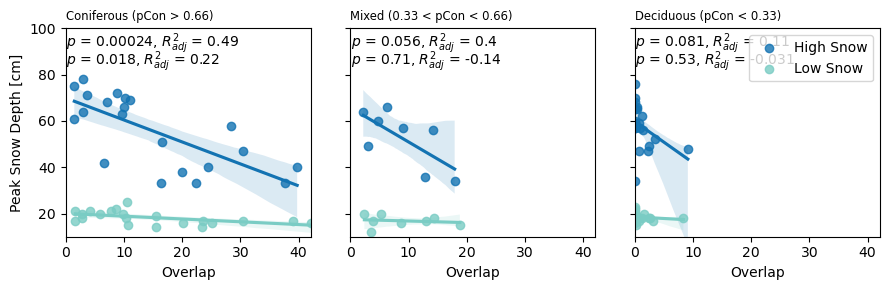

In [34]:
#Prep Data
bins = list(np.linspace(np.nanmin(modDat.pCon), np.nanmax(modDat.pCon), 4))
labels = ['Dense Deciduous', 'Mixed', 'Dense Coniferous']
modDat['Bin'] = pd.cut(modDat['pCon'], include_lowest = True, bins = bins, labels = labels)

#Plot
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize = (9, 3), 
                                    sharex = True, 
                                    sharey = True, 
                                    layout = 'tight')

sns.regplot(data = modDat[(modDat.Bin == 'Dense Coniferous') & (modDat.SYear == 2023)], x = 'OverlapMean', y = 'maxDepth', 
            ax = ax1, 
            color = pal[4], 
            label = 'High Snow')
sns.regplot(data = modDat[(modDat.Bin == 'Dense Coniferous') & (modDat.SYear == 2024)], x = 'OverlapMean', y = 'maxDepth', 
            ax = ax1, 
            color = pal[2], 
            label = 'Low Snow')
resultsDenseCon_high = smf.ols('maxDepth ~ OverlapMean', data = modDat[(modDat.Bin == 'Dense Coniferous') & (modDat.SYear == 2023)]).fit()
resultsDenseCon_low = smf.ols('maxDepth ~ OverlapMean', data = modDat[(modDat.Bin == 'Dense Coniferous') & (modDat.SYear == 2024)]).fit()
ax1.text(0.1, 92, r'$ p $ = ' + str(round_sig(resultsDenseCon_high.pvalues.OverlapMean, 2)) + r', $ R_{adj}^2 $ = ' + str(round_sig(resultsDenseCon_high.rsquared_adj, 2)))
ax1.text(0.1, 84, r'$ p $ = ' + str(round_sig(resultsDenseCon_low.pvalues.OverlapMean, 2)) + r', $ R_{adj}^2 $ = ' + str(round_sig(resultsDenseCon_low.rsquared_adj, 2)))
ax1.set_title('Coniferous (pCon > 0.66)', fontsize='small', loc='left')
ax1.set_ylabel('Peak Snow Depth [cm]')
ax1.set_xlabel('Overlap')

sns.regplot(data = modDat[(modDat.Bin == 'Mixed') & (modDat.SYear == 2023)], x = 'OverlapMean', y = 'maxDepth', 
            ax = ax2, 
            color = pal[4])
sns.regplot(data = modDat[(modDat.Bin == 'Mixed') & (modDat.SYear == 2024)], x = 'OverlapMean', y = 'maxDepth', 
            ax = ax2, 
            color = pal[2])
resultsMixed_high = smf.ols('maxDepth ~ OverlapMean', data = modDat[(modDat.Bin == 'Mixed') & (modDat.SYear == 2023)]).fit()
resultsMixed_low = smf.ols('maxDepth ~ OverlapMean', data = modDat[(modDat.Bin == 'Mixed') & (modDat.SYear == 2024)]).fit()
ax2.text(0.1, 92, r'$ p $ = ' + str(round_sig(resultsMixed_high.pvalues.OverlapMean, 2)) + r', $ R_{adj}^2 $ = ' + str(round_sig(resultsMixed_high.rsquared_adj, 2)))
ax2.text(0.1, 84, r'$ p $ = ' + str(round_sig(resultsMixed_low.pvalues.OverlapMean, 2)) + r', $ R_{adj}^2 $ = ' + str(round_sig(resultsMixed_low.rsquared_adj, 2)))
ax2.set_title('Mixed (0.33 < pCon < 0.66)', fontsize='small', loc='left')
ax2.set_ylabel(' ')
ax2.set_xlabel('Overlap')

sns.regplot(data = modDat[(modDat.Bin == 'Dense Deciduous') & (modDat.SYear == 2023)], x = 'OverlapMean', y = 'maxDepth', 
            ax = ax3, 
            color = pal[4], 
            label = 'High Snow')
sns.regplot(data = modDat[(modDat.Bin == 'Dense Deciduous') & (modDat.SYear == 2024)], x = 'OverlapMean', y = 'maxDepth', 
            ax = ax3, 
            color = pal[2], 
            label = 'Low Snow')
resultsDenseDec_high = smf.ols('maxDepth ~ OverlapMean', data = modDat[(modDat.Bin == 'Dense Deciduous') & (modDat.SYear == 2023)]).fit()
resultsDenseDec_low = smf.ols('maxDepth ~ OverlapMean', data = modDat[(modDat.Bin == 'Dense Deciduous') & (modDat.SYear == 2024)]).fit()
ax3.text(0.1, 92, r'$ p $ = ' + str(round_sig(resultsDenseDec_high.pvalues.OverlapMean, 2)) + r', $ R_{adj}^2 $ = ' + str(round_sig(resultsDenseDec_high.rsquared_adj, 2)))
ax3.text(0.1, 84, r'$ p $ = ' + str(round_sig(resultsDenseDec_low.pvalues.OverlapMean, 2)) + r', $ R_{adj}^2 $ = ' + str(round_sig(resultsDenseDec_low.rsquared_adj, 2)))
ax3.set_title('Deciduous (pCon < 0.33)', fontsize='small', loc='left')
ax3.set_ylabel(' ')
ax3.set_xlabel('Overlap')

ax1.set_xlim(0, max(modDat.OverlapMean))
ax1.set_ylim(10, 100)
ax3.legend(bbox_to_anchor = (1, 1))

#plt.savefig(fig_savepath + 'covertype_lairegression.pdf')

### PCA Plotting

In [20]:
#Import peak data for general PCA analysis
peakData = pd.read_csv('./data/original-data/peak-snow-data.csv')

In [22]:
#Merge with model results
peakData_expanded = pd.merge(peakData, modDat, on = ['stakes', 'maxDepth', 'SYear', 'northing', 'easting', 'zones', 'aspect', 'slope', 'watershed', 'pCon'])
peakData_expanded.columns

Index(['stakes', 'northing', 'easting', 'zones', 'aspect', 'slope',
       'watershed', 'SYear', 'maxDepth', 'lai5ring', 'avgDist_m', 'avgDBH_cm',
       'sdDist_m', 'sdDBH_cm', 'nTrees', 'basalArea_m2', 'nCo', 'nDom', 'nInt',
       'nSup', 'pCon', 'Stake_ID', 'LAI', 'DIST_FT', 'DIST_M', 'DBH_IN',
       'DBH_CM', 'DIST_FT_SD', 'DIST_M_SD', 'DBH_IN_SD', 'DBH_CM_SD', 'n',
       'Co', 'UnionMean', 'UnionSD', 'TotalMean', 'TotalSD', 'OverlapMean',
       'OverlapSD', 'UnionMean2', 'Bin', 'pCo', 'deltaResidual'],
      dtype='object')

In [23]:
'''Set PCA Data'''
#Switch this depending on average/maximum snow depth considerations
pca_data = peakData_expanded

#remove strings
pca_data_forplot = pca_data.drop(columns = ['stakes', 'zones', 'watershed', 'Bin', 'Stake_ID'])

#Simplify architecture data
pca_data_forplot = pca_data_forplot.drop(columns = ['northing', 'easting', 'SYear', 'lai5ring'])
#remove predictor variables 
pca_data = pca_data_forplot.drop(columns = ['maxDepth', 'UnionMean', 'UnionSD',
       'TotalMean', 'TotalSD', 'OverlapMean', 'OverlapSD', 'UnionMean2', 'deltaResidual'])

In [24]:
#Plot results against PCA grouping
#Standardize Data
scaler = StandardScaler()
scaler.fit(pca_data)
pca_data_scaled = scaler.transform(pca_data)
#Convert back to dataframe
pca_scaled = pd.DataFrame(data = pca_data_scaled, 
                            columns = pca_data.columns)

In [25]:
#Run PCA
pca = PCA(n_components = 7) #adjustable
pc = pca.fit_transform(pca_data_scaled)

#Extract variance values
prop_var = pca.explained_variance_ratio_
eigenvalues = pca.explained_variance_

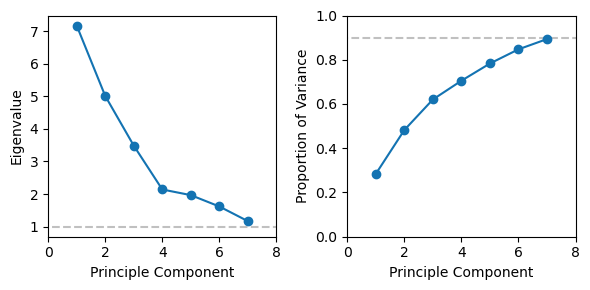

In [26]:
#Scree Plot
PCnumbers = np.arange(pca.n_components_) + 1

fig, [ax, ax2] = plt.subplots(1, 2, figsize = (6, 3), 
                              sharex = True, 
                              tight_layout = True)

ax.plot(PCnumbers, 
         eigenvalues, 
         'o-',
         color = pal[4])
ax.hlines(1, xmax = 0, xmin = 12, colors = 'silver', linestyles = '--', zorder = -1)
ax.set_ylabel('Eigenvalue')
ax.set_xlabel('Principle Component')

ax2.plot(PCnumbers, 
         np.cumsum(prop_var), 
         'o-', 
         color = pal[4])
ax2.hlines(0.90, xmax = 0, xmin = 12, colors = 'silver', linestyles = '--', zorder = -1)

ax2.set_ylabel('Proportion of Variance')
ax2.set_xlabel('Principle Component')

ax.set_xlim(0, 8)
ax2.set_ylim(0, 1)
#plt.savefig(fig_savepath + 'PCAeigenvalues.pdf', bbox_inches = 'tight')
plt.show()

In [27]:
'''BiPlot'''
def biplot(ax, data, score, coef, ipca1, ipca2, var, labels=None, leg=None, biVar=False):
 
    xs = score[:, ipca1]
    ys = score[:, ipca2]
    n = coef.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    jitterScale = 0.1

    if(biVar):
        sns.scatterplot(x = jitter(xs * scalex, jitterScale), y = jitter(ys * scaley, jitterScale), 
                        hue = data[var], 
                        s = 70,
                        ax = ax,
                        palette = 'vlag',
                        edgecolor = None,
                        legend = leg)   
    else:
        sns.scatterplot(x = jitter(xs * scalex, jitterScale), y = jitter(ys * scaley, jitterScale), 
                    hue = data[var], 
                    s = 70,
                    ax = ax,
                    palette = 'GnBu',
                    edgecolor = None,
                    legend = leg)
    
    '''
    for i in range(n):
        ax.arrow(0, 0, coef[i, ipca1], 
                  coef[i, ipca2], color = 'silver',
                  alpha = 0.5)
        ax.text(coef[i, ipca1]* 1.15, 
                 coef[i, ipca2] * 1.15, 
                 labels[i], 
                 color = 'silver', 
                 ha = 'center', 
                 va = 'center')
    '''
 
    ax.set_xlabel("PC{}".format(ipca1 + 1))
    ax.set_ylabel("PC{}".format(ipca2 + 1)) 

    ax.set_xlim(-0.7, 0.7)
    ax.set_ylim(-0.7, 0.7)

    #plt.title('Biplot of PCA')   

    #plt.show()

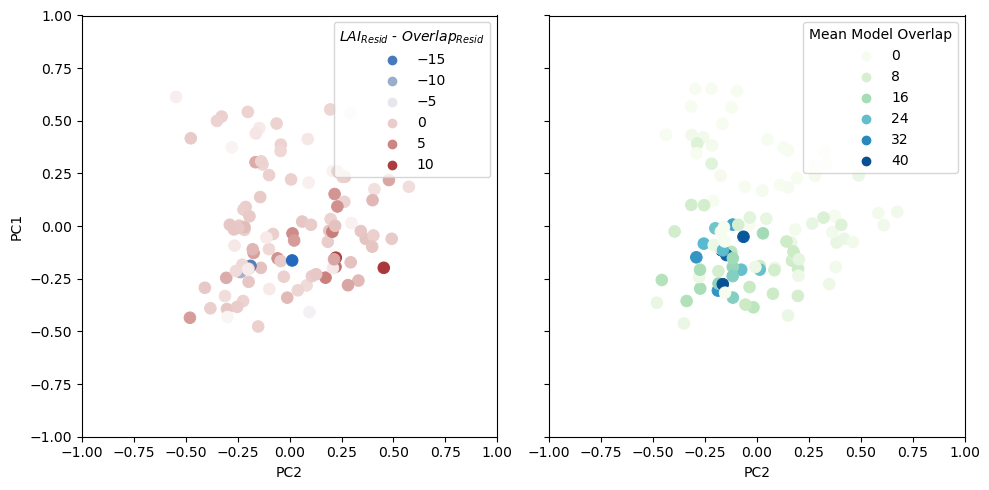

In [30]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize = (10, 5), 
                        tight_layout = True, 
                        sharex = True, 
                        sharey = True)

biplot(ax1, pca_data_forplot, pc, np.transpose(pca.components_), 1, 0, 'deltaResidual', list(pca_data.columns), True, True)
biplot(ax2, pca_data_forplot, pc, np.transpose(pca.components_), 1, 0, 'OverlapMean', list(pca_data.columns), True)

ax1.legend(title = r'$LAI_{Resid}$ - $Overlap_{Resid}$', loc = 'upper right')
ax2.legend(title = 'Mean Model Overlap', loc = 'upper right')
ax1.set_xlim(-1, 1)
ax1.set_ylim(-1, 1)
#plt.savefig(fig_savepath + 'PCAplots.pdf', bbox_inches = 'tight')
plt.show()